In [1]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from pandas.api.types import is_numeric_dtype
import os
from multiprocessing import Pool
from numpy.random import choice, seed
from datetime import datetime
from scipy.stats import binom
from statsmodels.stats.multitest import fdrcorrection
from functools import partial
import matplotlib.pyplot as plt
from scipy.stats.mstats import gmean
import sys
import seaborn as sns
import warnings
from copy import deepcopy
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Read taxonomy

In [2]:
df_tax = pd.read_csv('qiime2_output/taxonomy.tsv', sep="\t").rename({'Feature ID':'ASV'}, axis=1)
df_tax = df_tax[df_tax.Taxon.str.contains('d__Bacteria')]
df_tax = df_tax[~(df_tax.Taxon.str.contains('Chloroplast') | df_tax.Taxon.str.contains('Mitochondria'))]
df_tax['LowestTaxonomy'] = [t.split(';')[-1].strip() for t in df_tax.Taxon]
df_tax.head()

,ASV,Taxon,Confidence,LowestTaxonomy
0,9908fffab7ed4f3bec44cda2f5084d49,d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...,0.984443,g__Enterococcus
1,99deb3c5ecb022ec05609ebd1112a557,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,1.000000,g__Bacteroides
2,fd44d4cb468fd7dc9b3227867714ed87,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,1.000000,g__Bacteroides
3,3b010dbd9eae72a79f11af5d24eb3ca3,d__Bacteria; p__Verrucomicrobiota; c__Verrucom...,0.999999,g__Akkermansia
4,b15193fce14759d1c06728933e044af6,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,1.000000,g__Bacteroides


# Read sample data

In [3]:
df_sample = pd.read_csv('StoolSamplesTable.csv', index_col=0, encoding = 'unicode_escape')
df_sample.index.name = 'SampleID'
df_sample.head()

,Patient_ID,SampleDayRelativeToD1Chemo,16S_qPCR (copies/µl),Quality
SampleID,,,,
SRR7048546,7D001,4,unavailable,Adequate
SRR7048547,7D001,5,1009173,Adequate
SRR7048548,7D001,7,1678142,Adequate
SRR7048537,7D001,9,1067090,Adequate
SRR7048536,7D001,12,843037,Adequate


# Read count data

In [4]:
df_count = pd.read_csv('qiime2_output/feature-table/feature-table.from_biom.txt', sep="\t", index_col=0, skiprows=[0])
df_count = df_count.loc[df_tax['ASV']].T
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_sample.index).intersection(set(sample_ids_w_suff_reads))]
df_count = df_count.loc[:, (df_count != 0).any(axis=0)]
print("minimum total count = %d" % df_count.sum(axis=1).min())
df_relabun = df_count.div(df_count.sum(axis=1), axis=0)
df_relabun.head()

minimum total count = 1078


#OTU ID,9908fffab7ed4f3bec44cda2f5084d49,99deb3c5ecb022ec05609ebd1112a557,fd44d4cb468fd7dc9b3227867714ed87,3b010dbd9eae72a79f11af5d24eb3ca3,b15193fce14759d1c06728933e044af6,fd496fd32dc8c08ade2e8b6c9d8ee13d,836cd5ea357ad392c00a7e48d921be1d,9e18b43f389956ba5ac3ddf810f39cb6,09e996f449e880d1fd8f27d59e8d8b11,2c982937754e6321f861027032db80f7,...,14192646199d9cf06334c54aade286a5,21f93f2c1599c14f6c307b7e2cda69a2,a12a086985ef700cc8f5a0bd3c7b45c1,9853e2316d094a543ef4a956e03fadfd,6caa23f82d746bd829487c78de3b993a,90edbf2900f4aae18773de227c0b102f,e838089789ff8d5492411a71cd065527,d1fba67286934f6e1fd4a0a281af0e77,05f4400139040b710ee01cbaaf816295,fa08448d9b798f3e436c6bb6858495cb
SRR7048632,0.000000,0.039095,0.000000,0.000000,0.000000,0.001484,0.000000,0.0,0.000081,0.100605,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR8075067,0.000000,0.118502,0.000000,0.000000,0.000000,0.000000,0.152349,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR11424018,0.007437,0.000000,0.146162,0.320106,0.000000,0.001487,0.114210,0.0,0.003347,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR7048539,0.000000,0.000000,0.072226,0.000000,0.012559,0.005686,0.006842,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR11424016,0.020958,0.000000,0.015469,0.007485,0.000000,0.011976,0.021707,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Compute oral fraction and qPCR

In [5]:
# get oral bacterial fraction
df_blast_100 = pd.read_csv("qiime2_output/asv-sequences/blast_HMPv35oral/blast_HMPv35oral_p100.txt", sep="\t", comment="#", header=None)
df_blast_100.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']#
df_oral_total = df_relabun[set(df_blast_100.query_accver).intersection(df_relabun.columns)].sum(axis=1).to_frame()
df_oral_total.columns = ['OralFrac_HMPv35oral']
df_oral_total.index.name = 'SampleID'
df_oral_total['log10_OralFrac_HMPv35oral'] = np.log10(df_oral_total['OralFrac_HMPv35oral'])
df = pd.merge(df_sample, df_oral_total, left_index=True, right_index=True, how='inner')
df.columns = ['PatinetID','SampleDayRelativeToD1Chemo','qPCR16S','Quality','OralFrac_HMPv35oral','log10_OralFrac_HMPv35oral']
df = df[df['qPCR16S'] != "unavailable"]
df['qPCR16S'] = df['qPCR16S'].astype(float)
df['log10_qPCR16S'] = np.log10(df['qPCR16S'])
df['GutFrac_HMPv35oral'] = 1-df['OralFrac_HMPv35oral']
df['OralLoad_HMPv35oral'] = df['qPCR16S']*df['OralFrac_HMPv35oral']
df['GutLoad_HMPv35oral'] = df['qPCR16S']*df['GutFrac_HMPv35oral']
df['log10_OralLoad_HMPv35oral'] = np.log10(df['OralLoad_HMPv35oral'])
df['log10_GutLoad_HMPv35oral'] = np.log10(df['GutLoad_HMPv35oral'])
df.head()

,PatinetID,SampleDayRelativeToD1Chemo,qPCR16S,Quality,OralFrac_HMPv35oral,log10_OralFrac_HMPv35oral,log10_qPCR16S,GutFrac_HMPv35oral,OralLoad_HMPv35oral,GutLoad_HMPv35oral,log10_OralLoad_HMPv35oral,log10_GutLoad_HMPv35oral
SampleID,,,,,,,,,,,,
SRR7048547,7D001,5,1009173.0,Adequate,0.007487,-2.125676,6.003966,0.992513,7555.960349,1.001617e+06,3.878290,6.000702
SRR7048548,7D001,7,1678142.0,Adequate,0.030586,-1.514471,6.224829,0.969414,51328.370177,1.626814e+06,4.710357,6.211338
SRR7048537,7D001,9,1067090.0,Adequate,0.041907,-1.377709,6.028201,0.958093,44719.013694,1.022371e+06,4.650492,6.009609
SRR7048536,7D001,12,843037.0,Adequate,0.004093,-2.387990,5.925847,0.995907,3450.294940,8.395867e+05,3.537856,5.924066
SRR7048535,7D001,15,498384.0,Adequate,0.009588,-2.018290,5.697564,0.990412,4778.310809,4.936057e+05,3.679274,5.693380


# Plot the relative and absolute dynamics of oral and gut compositions

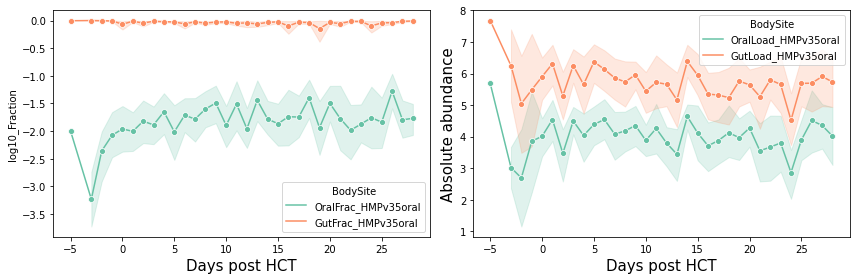

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharex=True)

df2plot = df[df.SampleDayRelativeToD1Chemo<=28].set_index('SampleDayRelativeToD1Chemo')[['OralFrac_HMPv35oral','GutFrac_HMPv35oral']].stack().reset_index()
df2plot.columns = ['SampleDayRelativeToD1Chemo', 'BodySite', 'Fraction']
df2plot = df2plot[df2plot.Fraction>0]
df2plot['log10_Fraction'] = np.log10(df2plot.Fraction)
_ = sns.lineplot(x="SampleDayRelativeToD1Chemo", y="log10_Fraction", hue='BodySite', data=df2plot, ax=ax[0], palette='Set2', marker='o')

df2plot = df[df.SampleDayRelativeToD1Chemo<=28].set_index('SampleDayRelativeToD1Chemo')[['OralLoad_HMPv35oral','GutLoad_HMPv35oral']].stack().reset_index()
df2plot.columns = ['SampleDayRelativeToD1Chemo', 'BodySite', 'Load']
df2plot = df2plot[df2plot.Load>0]
df2plot['Load'] = np.log10(df2plot.Load)
_ = sns.lineplot(x="SampleDayRelativeToD1Chemo", y="Load", hue='BodySite', data=df2plot, ax=ax[1], palette='Set2', marker='o')

#_ = ax[0].set_yscale('log')
#_ = ax[1].set_yscale('log')
_ = ax[0].set_xlabel('Days post HCT', fontsize=15)
_ = ax[1].set_xlabel('Days post HCT', fontsize=15)
#_ = ax[0].set_ylim([-0.1,1.1])
#_ = ax[1].set_ylim([5e5,5e8])#_ = ax[0].set_ylabel('Relative abundance', fontsize=15)
_ = ax[1].set_ylabel('Absolute abundance', fontsize=15)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("dynamics_of_oral_gut_bacterial.svg", format="svg")